# Exercise 1

For this exercise, we developed a Spectral Graph Partitioning algorith to cluster 3 different graphs. We also used 2 other pre-established implementations: Spectral Clustering from Scikit-learn and Power Iteration Clustering from PySpark.

Our implementation uses NetworkX, NumPy and Panda's Dataframes, as well as Scikit-learn's K-means algorithm.

## Imports

PySpark, Pandas, NumPy, Scipy, SKlearn and Matplotlib are the non-standard libraries required.

In [1]:
import gzip
import os.path as path
from io import SEEK_CUR
from typing import List

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
from pyspark.ml.clustering import PowerIterationClustering
from pyspark.sql import SparkSession
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans, SpectralClustering

## Prepare the data

There were 3 datasets used to test the different approaches:

`facebook_combined.txt.gz`

`ca-HepPh.txt.gz`

`PP-Pathways_ppi.csv.gz`

In [2]:
high_energy_dataset = 'ca-HepPh.txt.gz'
facebook_dataset = 'facebook_combined.txt.gz'
pathways_dataset = 'PP-Pathways_ppi.csv.gz'
data_folder = 'data'

chosen_dataset = facebook_dataset

Both `ca-HepPh.txt.gz` and `facebook_combined.txt.gz` datasets needed some preprocessing.
`ca-HepPh.txt.gz` had 4 lines before the node pairs, and these pairs were divided by tabs and the `facebook_combined.txt.gz` had its pairs divided by a space.

In [3]:
def load_dataset(dataset: str, data_folder: str = data_folder) -> pd.DataFrame:
    pt = path.join(data_folder, dataset)
    
    if dataset == 'ca-HepPh.txt.gz':
        with gzip.open(pt, 'rb') as f:
            c = f.read(1)
            while c == b'#':
                f.readline()
                c = f.read(1)
            f.seek(-1, SEEK_CUR)
            return pd.read_csv(f, sep='\t', header=None)
        
    elif dataset == 'facebook_combined.txt.gz':
        return pd.read_csv(pt, sep=' ', header=None)

    return pd.read_csv(pt, header=None)

Due to the networkx library needing the source and target column names to generate the graph, we decided to change the name of the columns.

In [4]:
dataset = load_dataset(chosen_dataset).rename(columns={0: 'source', 1: 'target'})

The next 2 dictionaries define the number of clusters that are going to be created and the number of components from the eigenvectors that are going to be used, depending on the dataset chosen.

These numbers were achieved by manual analysis of the eigengap values made for each dataset.

In [5]:
# Obtained by manual analysis of the first few eigenvectors
dataset_n_clusters = {
    high_energy_dataset: 15,
    facebook_dataset: 6,
    pathways_dataset: 12,
}

dataset_n_components = {
    high_energy_dataset: 20,
    facebook_dataset: 8,
    pathways_dataset: 12,
}

n_clusters = dataset_n_clusters[chosen_dataset]
n_components = dataset_n_components[chosen_dataset]

## Visualization

To visualize the clustering done by the different implementations, a small function was created with our prefered arguments for the nx.draw function from the networkX library.

In [ ]:
def plot_clustering(graph: nx.Graph, clustering_labels: List[int]):
    nx.draw(graph, node_color=clustering_labels, node_size=10, width = 0.1, cmap=plt.cm.jet)

In [ ]:
#plot_clustering(graph, clustering_labels)

## Our implementation

### Pre Processing - Create the Laplacian matrix

All graphs are treated as undirected graphs.

The first step of the Spectral clustering algorithm is to create a matrix representation of the graph, in this case we need the Laplacian Matrix of the graph.

To obtain this, we use the networkX library function `nx.laplacian_matrix` and then convert it to a dense format.

Before computing the Laplacian matrix we also remove some outliers in the high_energy and path_ways datasets by removing nodes with degree smaller than 7.

In [15]:
graph = nx.from_pandas_edgelist(dataset, source='source', target='target', create_using=nx.Graph)

if chosen_dataset == high_energy_dataset or chosen_dataset == pathways_dataset :
    remove = [node for node,degree in dict(graph.degree()).items() if degree < 7]
    graph.remove_nodes_from(remove)

laplacian_matrix = nx.laplacian_matrix(graph).todense()

### Decomposition (find eigenvalues and eigenvectors of L)

The next step of the algorithm is to find the eigenvalues/eigenvectors of the Laplacian matrix.

The eigenvectors will later be the "Features" used in the `fit` function of the Kmeans algorithm to do the clustering of the nodes.

In [10]:
eigenvalues, eigenvectors = eigs(laplacian_matrix.astype(np.float32), k=n_components, which='SR')
# eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

To obtain the ideal number of clusters of the clustering algorithm, the eigenvalues were sorted and then used to calculate the difference between sucessive values.

These differences are called the `eigengap` and by observing the first spike in these values, we can obtain a good estimate in the number of clusters to use in the algorithm.

/home/pedro/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Eigenvalue')

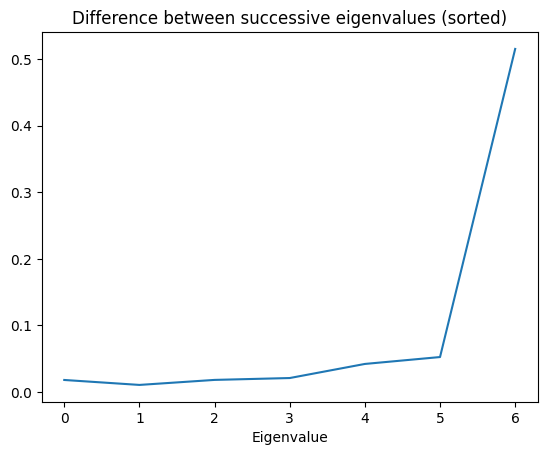

In [13]:
differences = np.ediff1d(np.sort(eigenvalues))

plt.plot(differences[:40])
plt.title('Difference between successive eigenvalues (sorted)')
plt.xlabel('Eigenvalue')

### Clustering

Create the features matrix from the first N eigenvectors.

The last step is to use a clustering algorithm with the eigenvectors as the argument for the fit function. For this implementation we used the `kmean` algorithm from scikit-learn and used the previously calculated eigenvectors as the "features". Due to these vectors being complex values, only the real part of the values were used.

In [14]:
clustering = KMeans(n_clusters=n_clusters).fit(eigenvectors.real)

/home/pedro/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


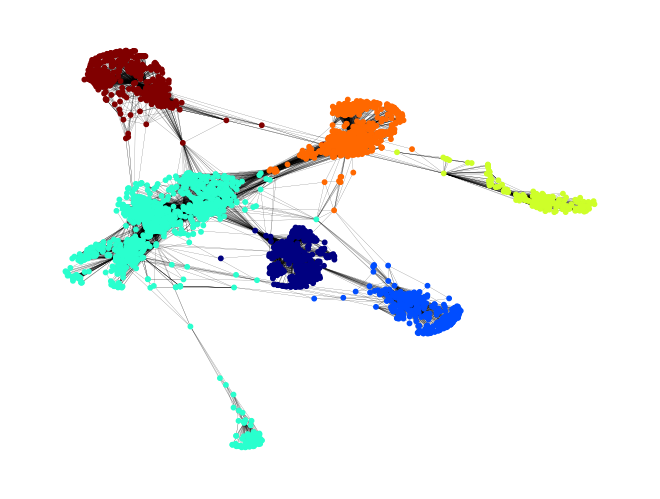

In [17]:
plot_clustering(graph,clustering.labels_)

## Scikit-learn Spectral Clustering

The second implementation tested was Scikit-learn's Spectral Clustering algorithm.
For this algorithm precomputed the affinity matrix of the graph with the `nx.adjacency_matrix` function from networkX and convert it to a dense format. We also chose Kmeans to assign_labels.

In [18]:
clustering = SpectralClustering(
    n_clusters=n_clusters,
    n_components=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=0
    ).fit(nx.adjacency_matrix(graph).todense())

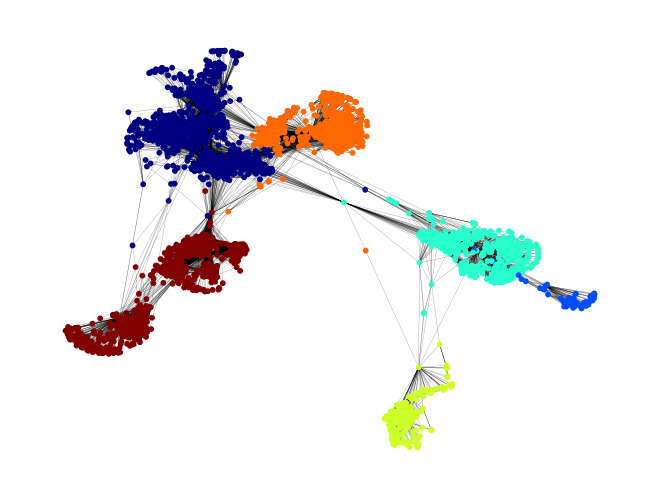

In [19]:
plot_clustering(graph, clustering.labels_)

## Spark Power Iteration Clustering

The last implementation tested was PySpark's Power iteration Clustering algorithm.

Spark is initialized, with as many worker threads as logical cores on the machine. We did not use a fixed value since the machines used for development had a different number of CPU cores.

In [ ]:
spark = SparkSession.builder \
    .appName('SpectralClustering') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

First, we convert the pandas dataframe previously created to a pyspark dataframe.

In [7]:
dataset_spark = spark.createDataFrame(dataset)

Then, due to the algorithm requiring a weigh attribute for each edge, we add a weight column (all at 1s).

In [8]:
dataset_spark = dataset_spark.withColumn('weight', F.lit(1))

Finally, we run the algorithm with the desired number of clusters, with a max number of iterations of 60 and initMode as random, because they produced the better results when testing.
Then we assign the calculated cluster ids to the nodes and sort the dataframe by node id.

In [ ]:
pic = PowerIterationClustering(k=n_clusters, maxIter=60, initMode="random", srcCol='source', dstCol='target', weightCol="weight")
dataset_clustered = pic.assignClusters(dataset_spark).toPandas().sort_values(by=['id'])

In [ ]:
# list of cluster labels
cluster_labels = dataset_clustered['cluster'].values

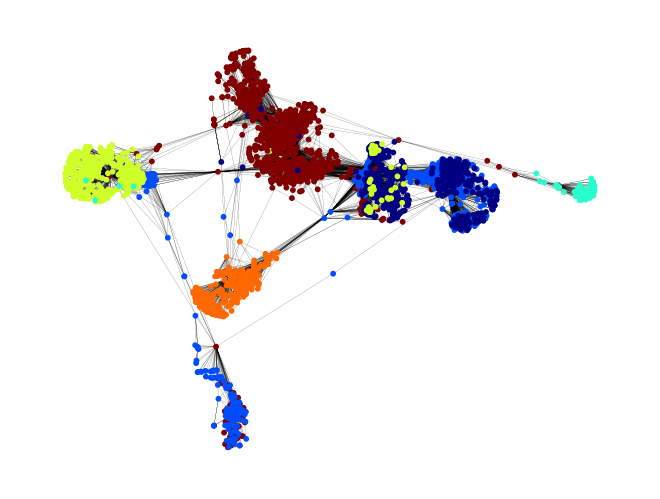

In [ ]:
plot_clustering(graph, cluster_labels)